# 1D linearized shallow-water equation with wind stress


In [1]:
cd(@__DIR__)

using Pkg; Pkg.activate(".")
# Pkg.resolve(); Pkg.instantiate(); Pkg.precompile()  # Uncomment if needed for reproducibility
using JLD2, Plots, Statistics, Printf, OrdinaryDiffEq, ComponentArrays, Flux

  Activating project at `~/Desktop/Deltares/Julia/gpu/wave surges/comparison`


In [2]:
# baseline global_scale reduced_input absolute_scale global_absolute_both minimal_global minimal_perstation
config_name = "baseline"  
surrogate = 2
output_dir = "configuration_experiments"
new = false

# init data 
wind_name = "periodic"            # periodic only (other unstable)
init_state = "flat"    # flat or bump or small_bump
longer = false                    # true for longer simulation time 
nothing

In [3]:
println("Loading configuration: $config_name")
result_file = joinpath(output_dir, "result_$(config_name)_s$(surrogate).jld2")
@load result_file result

config = result["config"]; corrective_model = result["corrective_model"]
H_corrected = result["H_corrected"]; U_corrected = result["U_corrected"]
H_scale_series = result["H_scale_series"]; U_scale_series = result["U_scale_series"]
scale_series = result["scale_series"]; alpha_series = result["alpha_series"]
train_losses = result["train_losses"]; scale_history = result["scale_history"]

println("✓ Loaded successfully")
println("Configuration: $(config["name"])")
println("RMSE Corrected: $(result["rmse_corrected"])")
println("Improvement: $((1 - result["rmse_corrected"]/result["rmse_surrogate"])*100)%")

Loading configuration: baseline
✓ Loaded successfully
Configuration: baseline
RMSE Corrected: 0.012496608842627478
Improvement: 70.5697946510499%


#### set up

In [4]:
const DEBUG = true
function debug(msg, override::Bool=DEBUG)
    if override
        println(msg)
    end
end

debug (generic function with 2 methods)

In [5]:
#include("model_1d_viscosity.jl")
include("model_1d_surge_wave.jl")
include("wind_forcing_functions.jl") 
include("normalization-utils.jl")

visualize_normalization (generic function with 1 method)

In [6]:
colors = palette(:bluegreenyellow)[1:6]
cur_colors = theme_palette(:auto)

In [7]:
# utils
function constant_func(t, value=0.0)
    return value
end

function run_model_and_extract(f::Wave1DSurge_cpu, x0, times, station_idxs)
    prob = ODEProblem(f, x0, (times[1], times[end]))
    sol = solve(prob, Rodas5(), saveat = times, isoutofdomain = (u, p, t) -> any([u.h[i] + D[i] < 0 for i in 1:length(u.h)]), reltol = 1e-8, abstol = 1e-10)

    n_time = length(times)
    n_stat = length(station_idxs)
    H = zeros(n_time, n_stat)
    U = zeros(n_time, n_stat)

    for (i, t) in enumerate(times)
        state = sol(t)
        H[i, :] = state.h[station_idxs]
        U[i, :] = state.u[station_idxs]
    end

    return sol, H, U
end

# Wind stress forcing as a function of time
function make_tau(amplitude=1.0, period=8*3600.0)
    return t -> (amplitude * sin(2π * t / period))^2
end

q_left(t) = constant_func(t, 0.0)
q_right(t) = constant_func(t, 0.0)

q_right (generic function with 1 method)

In [8]:
if longer 
    @load "data/$(init_state)_$(wind_name)_longer_parameters.jld2" params
else 
    @load "data/$(init_state)_$(wind_name)_parameters.jld2" params 
end 

for (k, v) in params
    eval(:($(Symbol(k)) = $v))
end

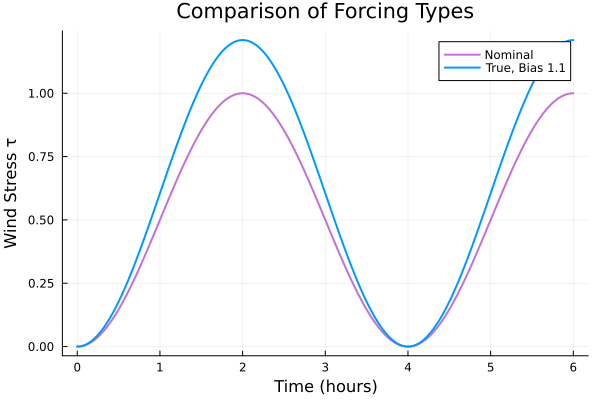

In [9]:
# import wind forcing 
if wind_name == "AR(2)"
    tau_nominal = make_tau_ar(amplitude=amplitude, coeffs=coeffs, sigma=sigma, seed=wind_seed)
    tau_true = make_tau_ar(amplitude=(amplitude * bias_factor), coeffs=coeffs, sigma=sigma, seed=wind_seed)

elseif wind_name == "piecewise"
    tau_nominal = make_tau_piecewise(amplitude=amplitude, avg_duration=avg_duration, noise_level=noise_level, seed=wind_seed) 
    tau_true = make_tau_piecewise(amplitude=(amplitude * bias_factor), avg_duration=avg_duration, noise_level=0.3, seed=wind_seed)

elseif wind_name == "zero"
    tau_nominal = make_tau_zero() # amplitude, period
    tau_true = make_tau_zero() # amplitude * bias_factor, period  

elseif wind_name == "constant"
    tau_nominal = make_tau_constant(amplitude=amplitude)
    tau_true = make_tau_constant(amplitude=(amplitude * bias_factor))

elseif wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)

elseif wind_name == "multi-frequency" 
    tau_nominal = make_tau_multifreq(amplitude=amplitude, periods=periods, weights=weights, seed=wind_seed)
    tau_true = make_tau_multifreq(amplitude=(amplitude * bias_factor), periods=periods, weights=weights, seed=wind_seed)
else 
    wind_name == "periodic"
    tau_nominal = make_tau_periodic(amplitude, period)
    tau_true = make_tau_periodic((amplitude * bias_factor), period)
end

# both wind functions compared
p = compare_forcings(Dict("Nominal" => tau_nominal,"True, Bias $bias_factor" => tau_true), times)
display(p)
nothing

In [10]:
# generate 'truth'
f_true = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_true, q_left, q_right)
sol_true, H_true, U_true = run_model_and_extract(f_true, x0, times, station_idxs)

# generate nominal data
f_nominal = Wave1DSurge_cpu(g, D, L, W, dx, nx, rho, C, tau_nominal, q_left, q_right)
sol_nominal, H_nominal, U_nominal = run_model_and_extract(f_nominal, x0, times, station_idxs)

nothing

In [11]:
function rollout_surrogate(surrogate_model, h0, u0, times, tau_func, mu_X, sigma_X, mu_Y, sigma_Y, D_stations, mask, n_stations, amplitude_scale; n_init_conditions=n_init_conditions)
    # Initialize arrays
    h_pred = zeros(length(times), length(h0))
    u_pred = zeros(length(times), length(u0))
    
    h_pred[1,:] = h0
    u_pred[1,:] = u0

    # Convert to vectors
    mu_X = Float32.(vec(mu_X))
    sigma_X = Float32.(vec(sigma_X))
    mu_Y = Float32.(vec(mu_Y))
    sigma_Y = Float32.(vec(sigma_Y))

    # Prepare IC encoding if using multi-IC surrogate
    ic_vec = nothing
    if use_multi_init
        ic_idx = ic_to_idx[correction_init_state]
        ic_vec = zeros(Float32, n_init_conditions)
        ic_vec[ic_idx] = 1.0f0
    end

    for k in 1:(length(times) - 1)
        # Build input vector
        input_vec = Float32[]
        tau_val = Float32(tau_func(times[k]))
        
        # Local features per station
        for i in 1:n_stations
            append!(input_vec, [h_pred[k, i], u_pred[k, i], D_stations[i], mask[i], tau_val, amplitude_scale])
        end

        # Append IC encoding if needed
        if ic_vec !== nothing
            append!(input_vec, ic_vec)
        end
        
        # Normalize
        input_norm = copy(input_vec)
        input_norm[surrogate_data[:norm_cols_X]] = (input_vec[surrogate_data[:norm_cols_X]] .- mu_X) ./ sigma_X
        input_norm[surrogate_data[:mask_cols_X]] = input_vec[surrogate_data[:mask_cols_X]]
        
        input_col = reshape(Float32.(input_norm), :, 1)

        # Predict
        pred_norm = surrogate_model(input_col)
        pred_vec = vec(Array(pred_norm))
        
        # Denormalize
        pred_unnorm = copy(pred_vec)
        pred_unnorm[surrogate_data[:norm_cols_Y]] = pred_vec[surrogate_data[:norm_cols_Y]] .* sigma_Y .+ mu_Y

        # Update state
        if surrogate_data[:predict_increment]
            h_pred[k + 1, :] = h_pred[k, :] .+ pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = u_pred[k, :] .+ pred_unnorm[(n_stations+1):end]
        else
            h_pred[k + 1, :] = pred_unnorm[1:n_stations]
            u_pred[k + 1, :] = pred_unnorm[(n_stations+1):end]
        end
    end

    return h_pred, u_pred  
end

rollout_surrogate (generic function with 1 method)

In [12]:
# import surrogate model data 
if false 
    @load "surrogates/$(init_state)_surrogate$(surrogate)_$(wind_name)_longer$(longer)" surrogate_model H_surrogate U_surrogate surrogate_data
else   
    if longer 
        @load "data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate)-longer.jld2" surrogate_model H_surrogate surrogate_data
    else 
        @load "data/multidata_$(init_state)_$(wind_name)_surrogate_$(surrogate).jld2" surrogate_model H_surrogate surrogate_data
    end 
end 

use_multi_init = isa(surrogate, AbstractDict) ? get(surrogate, :use_multi_init, false) : false

if use_multi_init
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, surrogate_data[:mu_X], 
                                                surrogate_data[:sigma_X], surrogate_data[:mu_Y], surrogate_data[:sigma_Y],
                                                surrogate_data[:D_stations], surrogate_data[:mask], surrogate_data[:n_stations], 1.0f0)
else
    H_surrogate, U_surrogate = rollout_surrogate(surrogate_model, H_nominal[1, :], U_nominal[1, :], times, tau_nominal, surrogate_data[:mu_X], 
                                                surrogate_data[:sigma_X], surrogate_data[:mu_Y], surrogate_data[:sigma_Y],
                                                surrogate_data[:D_stations], surrogate_data[:mask], surrogate_data[:n_stations], 1.0f0, n_init_conditions=nothing)
end 
nothing

#### results 

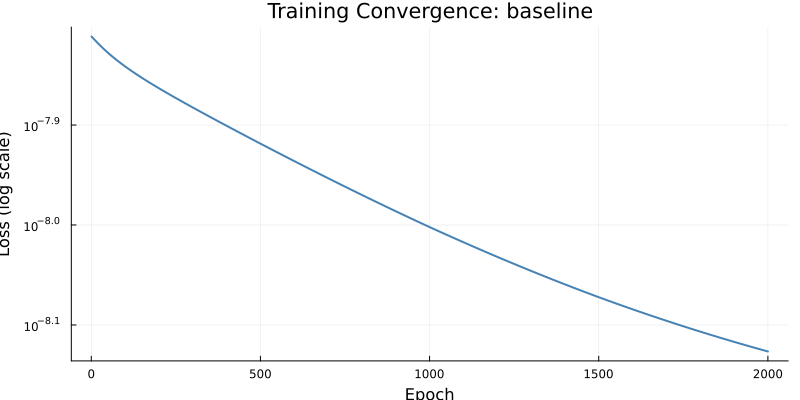

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/img/baseline_training_convergence.png"

In [13]:
p_train = plot(train_losses, yscale=:log10, xlabel="Epoch", ylabel="Loss (log scale)", color=:steelblue,
               title="Training Convergence: $(config["name"])", linewidth=2, legend=false, size=(800, 400))
display(p_train)
savefig("img/$(config_name)_training_convergence.png")

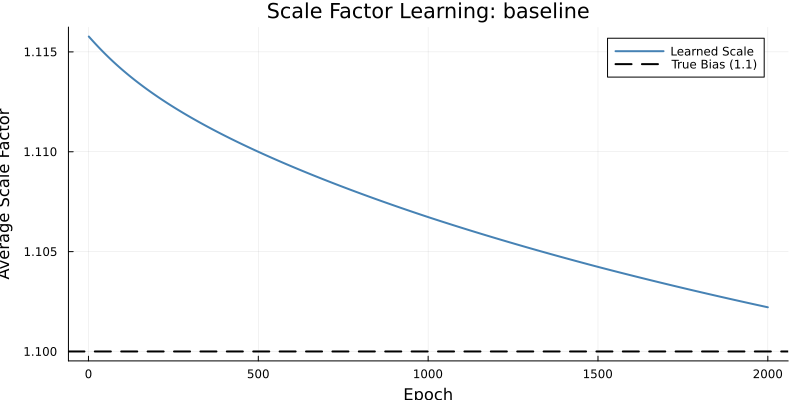

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/img/baseline_scale_evolution.png"

In [14]:
p_scale = plot(scale_history, xlabel="Epoch", ylabel="Average Scale Factor", color=:steelblue,
               title="Scale Factor Learning: $(config["name"])", linewidth=2, label="Learned Scale", size=(800, 400))
hline!([1.1], label="True Bias (1.1)", linestyle=:dash, linewidth=2, color=:black)
display(p_scale)
savefig("img/$(config_name)_scale_evolution.png")


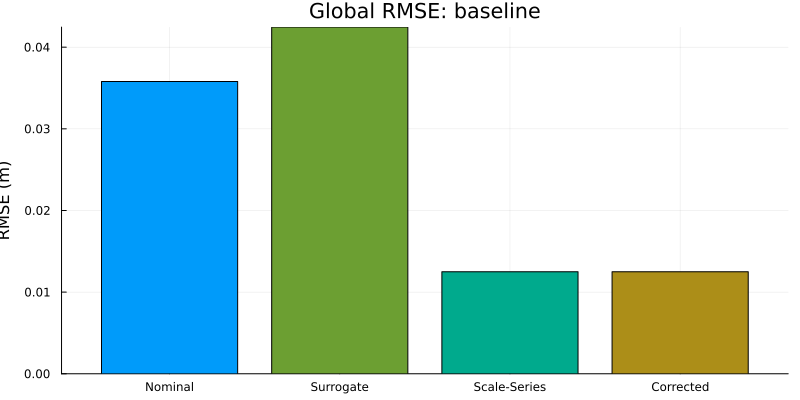

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/img/baseline_rmse_comparison.png"

In [15]:
rmse_nominal = result["rmse_nominal"]
rmse_surrogate = result["rmse_surrogate"]
rmse_scale_series = result["rmse_scale_series"]
rmse_corrected = result["rmse_corrected"]

p_rmse = bar(["Nominal", "Surrogate", "Scale-Series", "Corrected"], [rmse_nominal, rmse_surrogate, rmse_scale_series, rmse_corrected],
             ylabel="RMSE (m)", title="Global RMSE: $(config["name"])", legend=false, color=[cur_colors[1], cur_colors[end], cur_colors[9], cur_colors[5]], size=(800, 400))
display(p_rmse)
savefig("img/$(config_name)_rmse_comparison.png")

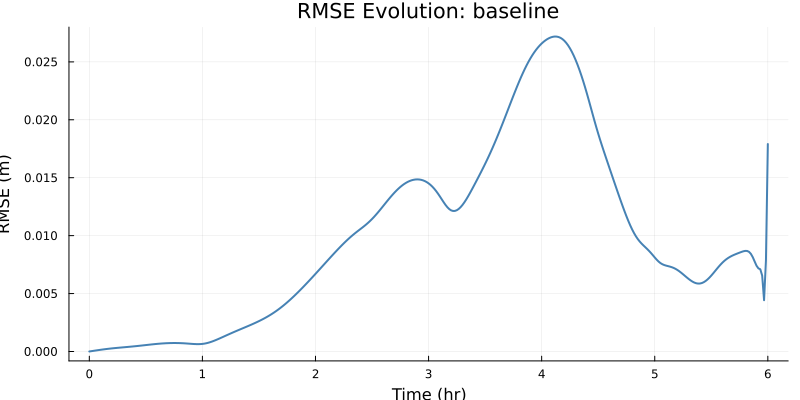

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/img/baseline_rmse_timeseries.png"

In [16]:
rmse_corrected_t = result["rmse_corrected_timeseries"]
times_hours = times[1:length(rmse_corrected_t)] ./ 3600  

p_rmse_t = plot(times_hours, rmse_corrected_t, xlabel="Time (hr)", ylabel="RMSE (m)", title="RMSE Evolution: $(config["name"])",
                linewidth=2, legend=false, size=(800, 400), color=:steelblue)
display(p_rmse_t)
savefig("img/$(config_name)_rmse_timeseries.png")


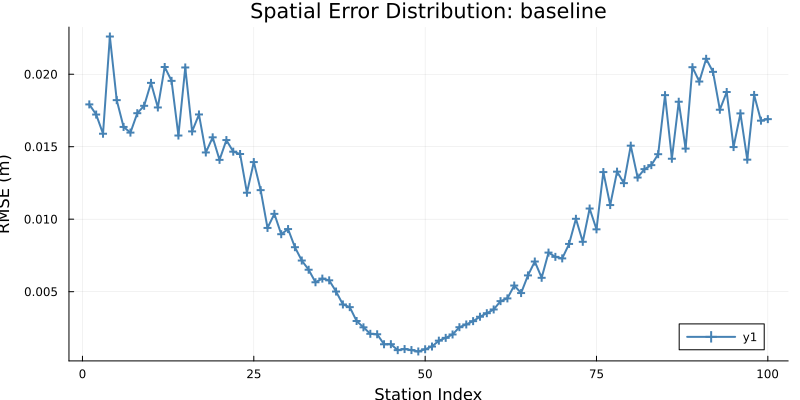

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/img/baseline_spatial_errors.png"

In [17]:
if !config["global_scale"]
    n_stations = size(H_corrected, 2)
    spatial_rmse = [sqrt(mean((H_corrected[:, s] .- H_true[:, s]).^2)) for s in 1:n_stations]
    
    p_spatial = plot(1:n_stations, spatial_rmse, xlabel="Station Index", ylabel="RMSE (m)", color=:steelblue, title="Spatial Error Distribution: $(config["name"])", 
                     linewidth=2, marker=:cross, size=(800, 400))
    display(p_spatial)
    savefig("img/$(config_name)_spatial_errors.png")
end

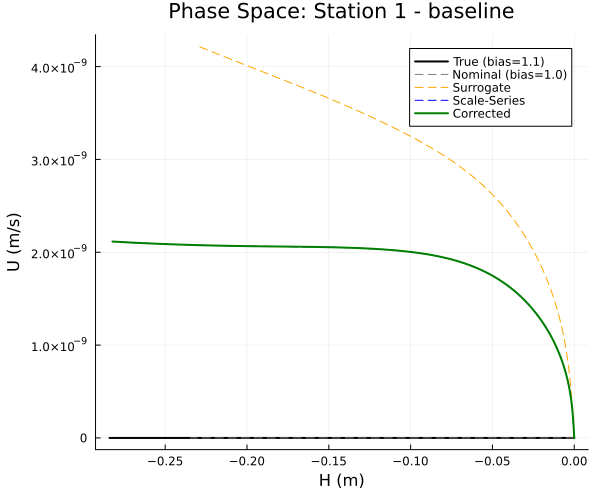

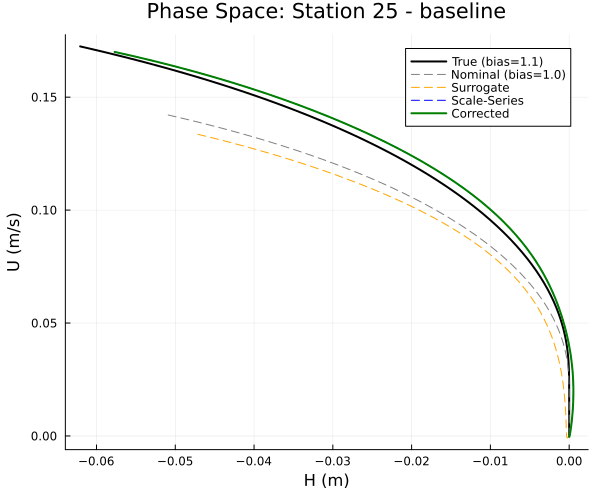

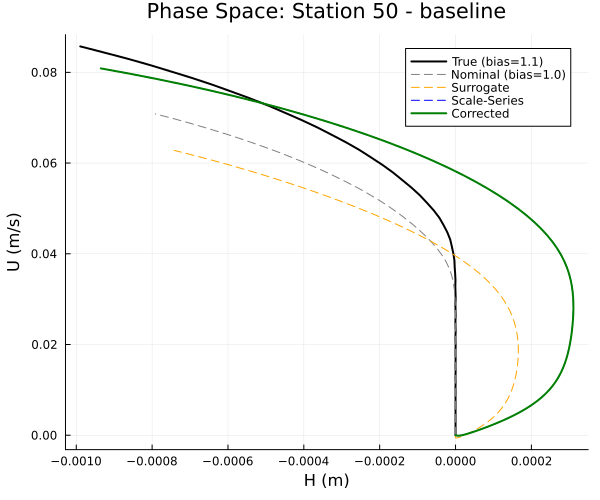

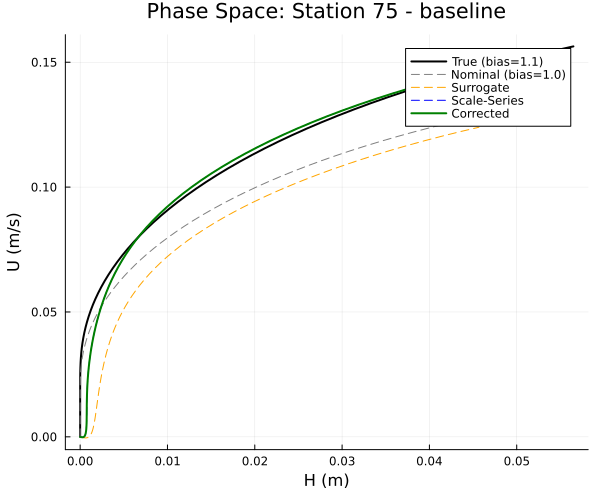

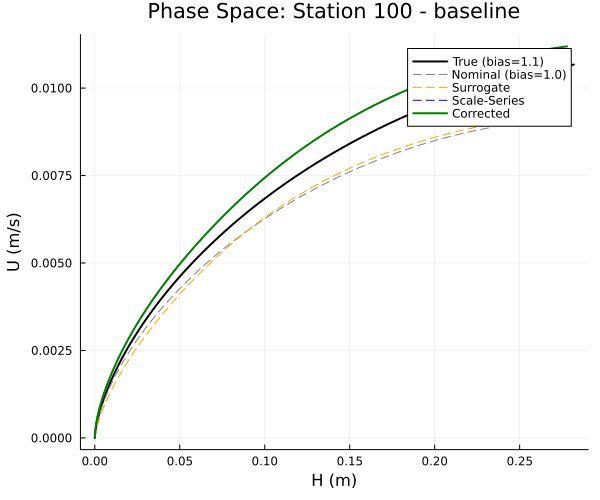

In [18]:
stations_to_plot = [1, 25, 50, 75, 100]
time_range = 1:100  # First 100 timesteps

for station_idx in stations_to_plot
    p_phase = plot(xlabel="H (m)", ylabel="U (m/s)", title="Phase Space: Station $station_idx - $(config["name"])", legend=:topright, size=(600, 500))
    
    plot!(H_true[time_range, station_idx], U_true[time_range, station_idx], label="True (bias=1.1)", linewidth=2, color=:black)
    plot!(H_nominal[time_range, station_idx], U_nominal[time_range, station_idx], label="Nominal (bias=1.0)", linestyle=:dash, color=:gray)
    plot!(H_surrogate[time_range, station_idx], U_surrogate[time_range, station_idx], label="Surrogate", linestyle=:dash, color=:orange)
    plot!(H_scale_series[time_range, station_idx], U_scale_series[time_range, station_idx], label="Scale-Series", linestyle=:dash, color=:blue)
    plot!(H_corrected[time_range, station_idx], U_corrected[time_range, station_idx], label="Corrected", linewidth=2, color=:green)
    
    display(p_phase)
    savefig("img/$(config_name)_phase_space_station$(station_idx).png")
end

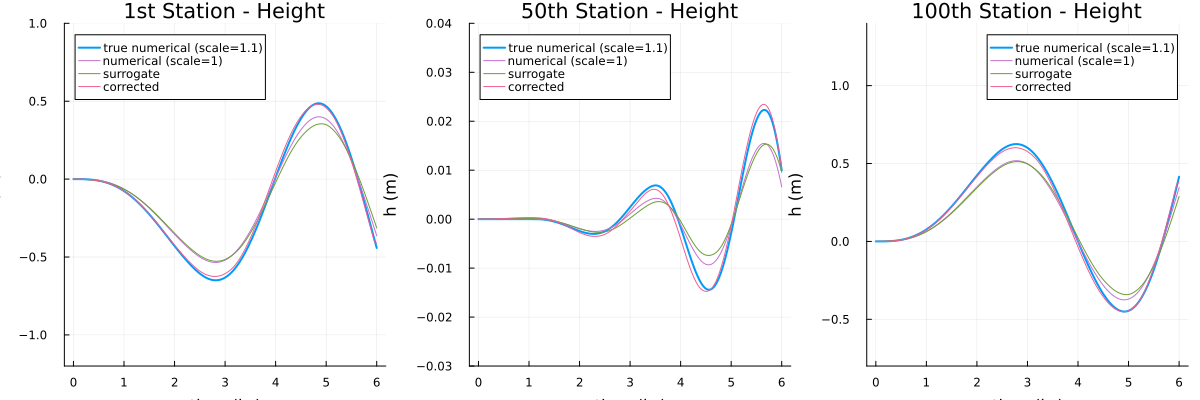

In [25]:
# Prepare the station indices
stations = [station_idxs[1], station_idxs[end ÷ 2], station_idxs[end]]
ylims = [(-1.2, 1.0), (-0.03, 0.04), (-0.8, 1.4)]
titles = ["1st Station - Height", "50th Station - Height", "100th Station - Height"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
    plot!(plt[i], times ./ 3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
    #plot!(plt[i], times ./ 3600, H_scale_series[:, s], label="scale-series", color=cur_colors[6], linestyle=:dash)
    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

# Optionally save the figure
display(plt)
#savefig(plt, "$(correction_init_state)_correction_rollout1_surrogate$(surrogate)_$(longer).png")

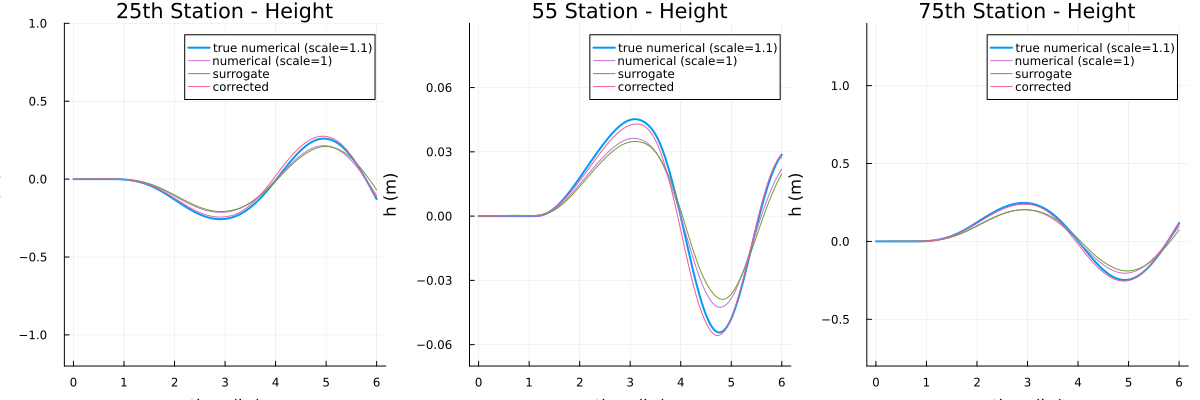

In [ ]:
# Prepare the station indices
stations = [station_idxs[end ÷ 4], station_idxs[end ÷ 2 + 5], station_idxs[3 * end ÷ 4]]
ylims = [(-1.2, 1.0), (-0.07, 0.09), (-0.8, 1.4)]
titles = ["25th Station - Height", "55th Station - Height", "75th Station - Height"]

# Create the 3-panel layout
plt = plot(layout = (1, 3), size=(1200, 400))

for (i, s) in enumerate(stations)
    plot!(plt[i], times ./ 3600, H_true[:, s], label="true numerical (scale=$bias_factor)", lw=2, ylim=ylims[i])
    plot!(plt[i], times ./ 3600, H_nominal[:, s], label="numerical (scale=1)", color=cur_colors[4])
    plot!(plt[i], times ./ 3600, H_surrogate[:, s], label="surrogate", color=cur_colors[end])
    plot!(plt[i], times ./ 3600, H_corrected[:, s], label="corrected", color=cur_colors[7])
    #plot!(plt[i], times ./ 3600, H_scale_series[:, s], label="scale-series", color=cur_colors[6], linestyle=:dash)
    
    xlabel!(plt[i], "time (hr)"); ylabel!(plt[i], "h (m)"); title!(plt[i], titles[i])
end

# Optionally save the figure
display(plt)
#savefig(plt, "$(correction_init_state)_correction_rollout1_surrogate$(surrogate)_$(longer).png")

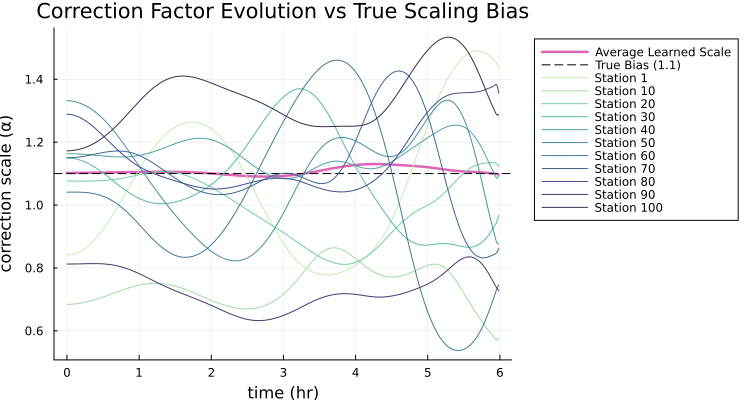

In [29]:
if config["global_scale"]
    # For global scale case - scale_series is Vector{Float32}
    p = plot(times[1:end-1] ./ 3600, scale_series, label="Global Correction Factor", linewidth=2, color=cur_colors[11])
    hline!([bias_factor], label="True Bias ($bias_factor)", ls=:dash, linewidth=2, color=:black)
    
    xlabel!("Time (hr)"); ylabel!("Correction Scale (α)"); title!("Global Correction Factor Evolution vs True Scaling Bias")
    savefig(p, joinpath(save_dir, "global_correction_factor.png"))
    display(p)
else
    # For per-station case - scale_series is Vector{Vector{Float32}}
    grad = cgrad(:deep)
    typical_stations = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    colors = [grad[i] for i in range(0.1, stop=0.9, length=length(typical_stations))]
    labels = ["Station $(s)" for s in typical_stations]
    
    # Compute average scale (mean across stations at each time step)
    avg_scale = [mean(vec(alpha_vec)) for alpha_vec in scale_series]
    p = plot(times[1:end-1] ./ 3600, avg_scale, label="Average Learned Scale", linewidth=2.5, color=cur_colors[end-1], legend=:outertopright, size=(750,400))
    hline!([bias_factor], label="True Bias ($bias_factor)", ls=:dash, linewidth=1, color=:black)
    
    # Plot individual station alphas
    for (i, station_idx) in enumerate(typical_stations)
        if haskey(alpha_series, station_idx) && !isempty(alpha_series[station_idx])
            plot!(p, times[1:end-1] ./ 3600, alpha_series[station_idx], label=labels[i], linewidth=1.0, color=colors[i])
        end
    end
    
    xlabel!(p, "time (hr)"); ylabel!(p, "correction scale (α)"); title!(p, "Correction Factor Evolution vs True Scaling Bias")
    savefig(p, joinpath(output_dir, "correction_alpha_bias_surrogate$(surrogate)_$(longer).png"))
    display(p)
end


In [20]:
println("\n" * "-"^70)
println("STATISTICAL SUMMARY: $(config["name"])")
println("-"^70)

println("\nConfiguration:")
for (key, val) in config
    if key != "name"
        println("  $key: $val")
    end
end

println("\nPerformance:")
@printf("  RMSE Nominal:       %.6f m\n", rmse_nominal)
@printf("  RMSE Surrogate:     %.6f m\n", rmse_surrogate)
@printf("  RMSE Scale-Series:  %.6f m\n", rmse_scale_series)
@printf("  RMSE Corrected:     %.6f m\n", rmse_corrected)


----------------------------------------------------------------------
STATISTICAL SUMMARY: baseline
----------------------------------------------------------------------

Configuration:
  predict_increment: true
  global_scale: false
  predict_scale_increment: true
  use_multi_data: true
  complete_input: true
  use_multi_init: false

Performance:
  RMSE Nominal:       0.035796 m
  RMSE Surrogate:     0.042462 m
  RMSE Scale-Series:  0.012497 m
  RMSE Corrected:     0.012497 m


In [21]:

improvement_surrogate = (1 - rmse_corrected/rmse_surrogate) * 100
improvement_nominal = (1 - rmse_corrected/rmse_nominal) * 100

println("\nImprovements:")
@printf("  vs Surrogate:  %+.2f%%\n", improvement_surrogate)
@printf("  vs Nominal:    %+.2f%%\n", improvement_nominal)

println("\nScale Statistics:")
@printf("  Final Alpha Mean: %.4f\n", result["final_alpha_mean"])
@printf("  Target:           %.4f\n", 1.1)
@printf("  Error:            %.4f\n", result["alpha_error"])

println("\nTraining:")
@printf("  Time:             %.2f seconds\n", result["training_time"])
@printf("  Convergence:      epoch %d\n", result["convergence_epoch"])



Improvements:
  vs Surrogate:  +70.57%
  vs Nominal:    +65.09%

Scale Statistics:
  Final Alpha Mean: 1.1024
  Target:           1.1000
  Error:            0.0024

Training:
  Time:             99.16 seconds
  Convergence:      epoch 1


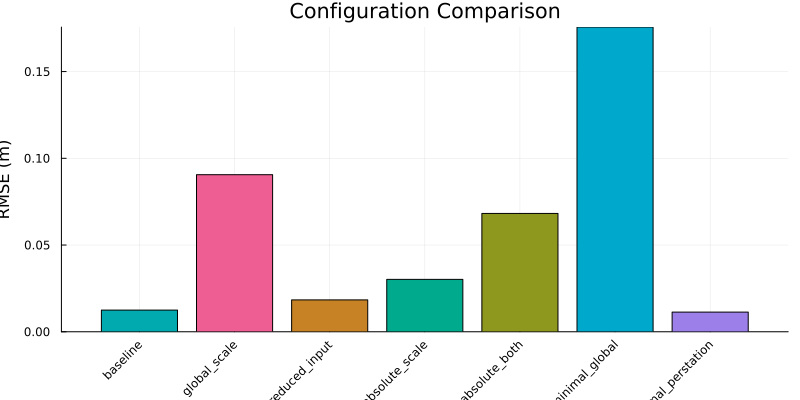

"/Users/sara/Desktop/Deltares/Julia/gpu/wave surges/comparison/img/multi_config_comparison.png"

In [22]:
# Load all configurations
configs_to_compare = ["baseline", "global_scale", "reduced_input", "absolute_scale", "global_absolute_both", "minimal_global", "minimal_perstation"]
all_configs_data = Dict()

for cfg_name in configs_to_compare
    file = joinpath(output_dir, "result_$(cfg_name)_s$(surrogate).jld2")
    @load file result
    all_configs_data[cfg_name] = result
end

# Multi-config RMSE comparison
p_multi = bar([cfg for cfg in configs_to_compare], [all_configs_data[cfg]["rmse_corrected"] for cfg in configs_to_compare],
              ylabel="RMSE (m)", title="Configuration Comparison", legend=false, xrotation=45, size=(800, 400), color=cur_colors[6:length(configs_to_compare)+5])
display(p_multi)
savefig("img/multi_config_comparison.png")